In [1]:
# Importing standard packages for data exploration and processing.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


# Our data has no header row.
data = pd.read_csv('data/kaggle/1_steam-200k.csv', header=None)
data.head()

,0,1,2,3,4
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       200000 non-null  int64  
 1   1       200000 non-null  object 
 2   2       200000 non-null  object 
 3   3       200000 non-null  float64
 4   4       200000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.6+ MB


In [3]:
data.describe()

,0,3,4
count,2.000000e+05,200000.000000,200000.0
mean,1.036559e+08,17.874384,0.0
std,7.208074e+07,138.056952,0.0
min,5.250000e+03,0.100000,0.0
25%,4.738420e+07,1.000000,0.0
50%,8.691201e+07,1.000000,0.0
75%,1.542309e+08,1.300000,0.0
max,3.099031e+08,11754.000000,0.0


In [4]:
# The last column is useless.
data.drop(4, axis=1, inplace=True)

# Current column names are not very informative, are they?
header = ['Player_id', 'Game', 'Action', 'Amount']
data.columns = header
data.head()

,Player_id,Game,Action,Amount
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


In [5]:
# Not all people that buy a game ever play it.
data['Action'].value_counts()

purchase    129511
play         70489
Name: Action, dtype: int64

In [6]:
# Is a purchase always for one game, and how many hours were played in total?
data.groupby('Action')['Amount'].sum()

Action
play        3445365.8
purchase     129511.0
Name: Amount, dtype: float64

In [7]:
# We not only need to aggregate the data to a game level but also store number of purchases and hours of play separately.
summary = data.pivot_table(index='Game', columns='Action', values='Amount', aggfunc='sum')
summary.reset_index(inplace=True)
summary.rename_axis(None, axis=1, inplace=True)
summary.head()

,Game,play,purchase
0,007 Legends,0.7,1.0
1,0RBITALIS,1.2,3.0
2,1... 2... 3... KICK IT! (Drop That Beat Like a...,20.0,7.0
3,10 Second Ninja,5.9,6.0
4,"10,000,000",3.6,1.0


In [8]:
# It would make more sense to have the 'Purchase' column before 'Play'.
summary.columns = ['Game', 'Play', 'Purchase']
summary = summary[['Game', 'Purchase', 'Play']]
summary.head()

,Game,Purchase,Play
0,007 Legends,1.0,0.7
1,0RBITALIS,3.0,1.2
2,1... 2... 3... KICK IT! (Drop That Beat Like a...,7.0,20.0
3,10 Second Ninja,6.0,5.9
4,"10,000,000",1.0,3.6


In [9]:
summary.describe()

,Purchase,Play
count,5155.000000,3600.000000
mean,25.123375,957.046056
std,101.572586,17930.737469
min,1.000000,0.100000
25%,2.000000,3.100000
50%,5.000000,15.100000
75%,18.000000,97.575000
max,4841.000000,981684.600000


Quite a lot of games that were bought but never played in our data, is it not? 5155 games have at least one purchase while only 3600 games have at least one person that played them. Since we are not really interested in such unpopular games, let us put some minimum qualifying restrictions.

In [10]:
summary = summary[(summary['Purchase'] >= 10) & (summary['Play'] >= 100)]
summary.reset_index(drop=True, inplace=True)

# What we are really interested in is the average number of hours played by someone who has purchased that game.
summary['Conversion'] = summary['Play'] / summary['Purchase']
summary = summary.round(2)
summary.head()

,Game,Purchase,Play,Conversion
0,3DMark,18.0,240.8,13.38
1,7 Days to Die,103.0,4075.5,39.57
2,A.V.A - Alliance of Valiant Arms,63.0,109.1,1.73
3,APB Reloaded,262.0,9237.2,35.26
4,ARK Survival Evolved,163.0,13593.1,83.39


In [11]:
len(summary)

783

783 games, not bad. We need to remember that the data used here is nowhere near the actual popularity of the games as it only contains 200,000 actions and is rather old. Moreover, some games might not be properly represented due to the small scale of dataset. However, we can presume that at least for the most popular games that should not be the case. And let us create a shortlist of games with stricter qualifying requirements.

In [12]:
shortlist = summary[(summary['Purchase'] >= 100) & (summary['Play'] >= 1000)]
shortlist.reset_index(drop=True, inplace=True)
shortlist.head()

,Game,Purchase,Play,Conversion
0,7 Days to Die,103.0,4075.5,39.57
1,APB Reloaded,262.0,9237.2,35.26
2,ARK Survival Evolved,163.0,13593.1,83.39
3,AdVenture Capitalist,222.0,6067.7,27.33
4,Age of Empires II HD Edition,238.0,6858.5,28.82


In [13]:
len(shortlist)

155

155 games, now that should be much easier to look at and analyse one by one when we need it. But let us first start by analysing the general statistics for both dataframes.

In [14]:
summary.describe()

,Purchase,Play,Conversion
count,783.000000,783.000000,783.000000
mean,111.197957,4303.685185,21.597484
std,237.255413,38279.790989,40.289269
min,10.000000,100.300000,0.190000
25%,29.000000,200.100000,4.945000
50%,57.000000,468.500000,10.160000
75%,113.500000,1418.200000,20.540000
max,4841.000000,981684.600000,385.570000


Very interesting. Almost 75% of games have less than an average amount of purchases, which means that the mean is largely driven by a smaller number of very popular games. That effect stays the same for conversion rates and is even more pronounced for the total number of hours recorded, for which the mean is three times the 75% quantile value.

And just look at the max values for all columns. One game was purchased almost 5,000 times while we only had 130,000 purchases in our original dataset, meaning that around 3,8% of all purchases were for that one particular game - 44 times the average of summary dataset.

Similarly, some game has 228 times the average play time of summary dataset. Even when compared to the original dataset before eliminating less popular games, it accounts for 28,5% of all play time! That one game alone has more play time than the least played 75% of the games combined.

Now conversion rate is a much more tricky subject. Not all games possess the same level of replayability to begin with, as many games are storyline-driven and intended for a certain amount of play time. It is often multiplayer or sandbox games that can rack up a huge amount of hours played. As such, it is not really fair to compare the conversion rates of different games without taking into consideration the nature of these games. For example, we could compare the conversion rates of different strategy games.

In [15]:
shortlist.describe()

,Purchase,Play,Conversion
count,155.000000,155.000000,155.000000
mean,319.477419,18460.578710,34.450194
std,461.029598,84669.048622,44.773612
min,100.000000,1002.800000,2.530000
25%,142.000000,1816.950000,10.165000
50%,207.000000,3581.900000,17.860000
75%,313.000000,8840.300000,38.690000
max,4841.000000,981684.600000,310.660000


Despite further restricting our dataset we are observing the exact same behaviour as before. The means for both purchases and conversion rates are around the 75% quantile value while the mean for play time exceeds it, although not as severely as before. It appears that such behaviour might be standard for any random dataset of games that we get, at the time this data was collected at least.

What is interesting is that while the max values for both purchases and plays stayed the same, the maximum value for conversion rate has dropped from 385 to 310. Apparently, some game was extremely popular among the people who bought it but did not have enough purchases to make it into the shortlist. Would be very interesting to take a look at that game.

In [16]:
# Top purchased.
summary.nlargest(5, 'Purchase')

,Game,Purchase,Play,Conversion
208,Dota 2,4841.0,981684.6,202.79
648,Team Fortress 2,2323.0,173673.3,74.76
736,Unturned,1563.0,16096.4,10.30
143,Counter-Strike Global Offensive,1412.0,322771.6,228.59
335,Half-Life 2 Lost Coast,981.0,184.4,0.19


In [17]:
# Top played.
summary.nlargest(5, 'Play')

,Game,Purchase,Play,Conversion
208,Dota 2,4841.0,981684.6,202.79
143,Counter-Strike Global Offensive,1412.0,322771.6,228.59
648,Team Fortress 2,2323.0,173673.3,74.76
140,Counter-Strike,856.0,134261.1,156.85
581,Sid Meier's Civilization V,596.0,99821.3,167.49


In [18]:
# Top conversion rate.
summary.nlargest(5, 'Conversion')

,Game,Purchase,Play,Conversion
279,Football Manager 2012,80.0,30845.8,385.57
281,Football Manager 2014,80.0,30574.8,382.18
277,Football Manager 2010,38.0,13126.7,345.44
278,Football Manager 2011,34.0,11336.8,333.44
280,Football Manager 2013,104.0,32308.6,310.66


Without much surprise, the first spot for both number of purchases and total hours played were taken by Dota 2 which is a very much a cult game. We also have game such as 'Counter-Strike', 'Counter-Strike Global Offensive' and 'Sid Meier's Civilization V' in the tops which all look perfectly normal. 'Team Fortress 2' is also in the top played games despite having a considerably smaller conversion rates than the rest of the top. Most of these games are primarily online-based and 'Civilization V' is a sandbox game.

Three games deserve a closer look, all of which are featured in the top purchased games. However, 'Unturned' takes the third spot in bought games despite having a rather small play time and the iconic 'Half-Life 2 Lost Coast' has many purchases and barely any play time. It is an interesting example of being hailed as a great game (and thus bought frequently) despite nobody ever playing it.

But the most interesting thing is the top for the conversion rate. All of it is taken by different editions of 'Football Manager' franchise. What makes it so special? Is it an extreme replayability or extreme loyalty of the franchise's fanbase? Probably a bit of both, but also a third and very important factor.

In 'Football Manager', you do not need to actively interact with the game all the time. Since you act as a team's manager, a lot of the time the game would be running in the background simulating all matches of a season until a player's intervention is necessary. That is the case for most sports management games, and a good example of why conversion rate (and play time in general) can be ill-representative of the actual popularity of the game - same as with 'Half-Life 2 Lost Coast' and its many purchases.

Let us plot the behaviour of all three parametres to show graphically the differences and similarities. Since the min and max values are very different, we are going to use logarithms. In effect, the growth of a feature's logarithm would be close enough to the rate at which that particular feature grows.

In [19]:
def plot_ascending(df):
    name = df.name
    values = df.sort_values()
    values.reset_index(drop=True, inplace=True)
    
    # Rescaling the values to compare graphs with each other.
    values = (values - values.min()) / (values.max() - values.min())
    values = np.log(values + 1)
    plt.plot(values, label=name)

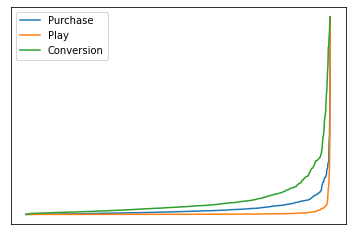

In [20]:
for column in summary.columns[1:]:
    plot_ascending(summary[column])

plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

Overall, the three lines seem to show a fairly similar behaviour. The growth rates for all of them are skewed towards a smaller number of more popular games located on the right of the graph. That effect is stronger for the number of purchases than the conversion rate, and extremely strong for the total play time. Let us better illustrate it with a plot of cumulative values. The conversion rate is not going to be included in the next graph as it makes little sense for us to calculate the cumulative values of it.

In [21]:
def plot_cumulative(df):
    name = df.name
    values = df.sort_values()
    values.reset_index(drop=True, inplace=True)
    
    # We need to both calculate the cumulative values and rescale them as proportion of total.
    values = values.cumsum()
    values = values / values.max()
    plt.plot(values, label=name)

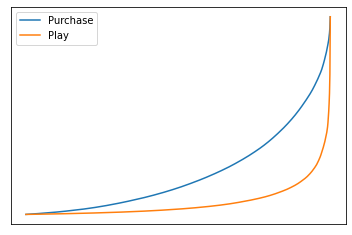

In [22]:
for column in summary.columns[1:-1]:
    plot_cumulative(summary[column])

plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

Indeed, we can see a huge drop here. Both graphs now look much smoother than when we were looking at the growth rates, although the cumulative values of hours played are still extremely skewed compared to the number of purchases. Should not be too much of a surprise though, since we have already discovered before that the most played game alone accounts for 28,5% of all play time.